In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from scipy.stats import pearsonr, spearmanr

c:\Users\dv516.old\Anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:

df_train = pd.read_csv("../data/nonlin_simpson/train.csv", header=None)
df_train.head()

,0,1,2,3
0,0.375,-0.588,-0.597,-0.660
1,1.240,-0.779,-0.825,-0.424
2,0.679,-0.745,-0.663,-0.678
3,-0.980,0.566,-1.040,-0.858
4,0.366,-0.595,-0.905,-0.734


In [3]:
print(df_train.describe())
print(df_train.info())
# print(df_train.dtypes)


                 0            1            2            3
count  2000.000000  2000.000000  2000.000000  2000.000000
mean     -0.014330    -0.079374    -1.160573    -0.799478
std       1.001974     0.731893     1.088227     0.508753
min      -3.850000    -1.490000    -6.730000    -2.070000
25%      -0.698500    -0.635250    -1.892500    -1.140000
50%      -0.012000    -0.171000    -1.200000    -0.888000
75%       0.688000     0.380500    -0.509000    -0.579000
max       3.620000     3.430000     3.530000     2.460000
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       2000 non-null   float64
 1   1       2000 non-null   float64
 2   2       2000 non-null   float64
 3   3       2000 non-null   float64
dtypes: float64(4)
memory usage: 62.6 KB
None


In [4]:
# # Count missing values in each column
# print(df.isnull().sum())

# # Optionally, visualize missing data
# import seaborn as sns
# import matplotlib.pyplot as plt

# sns.heatmap(df.isnull(), cbar=False)
# plt.show()

# df.dropna(inplace=True)  # Drops all rows with any missing values
# df.fillna(df.mean(), inplace=True)  # Fills with the mean value of each column

Pairplots

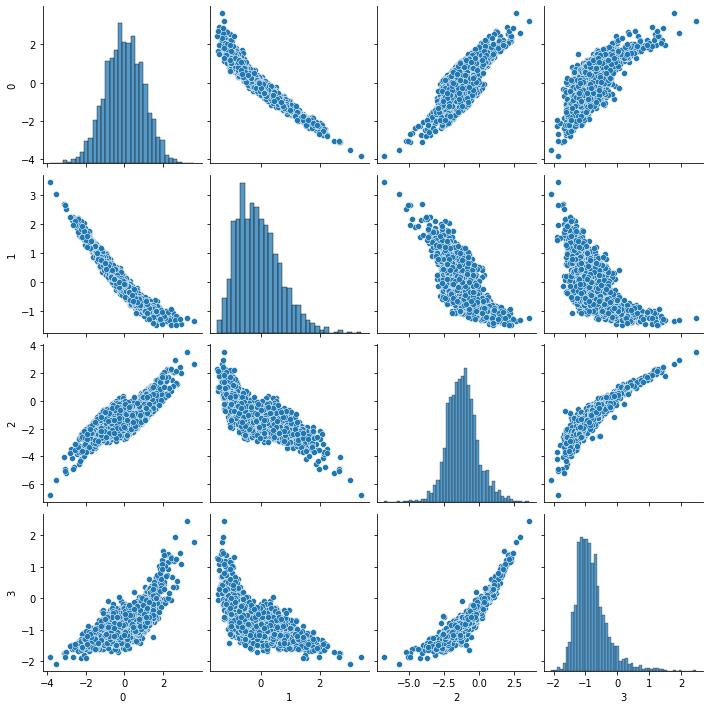

In [5]:
sns.pairplot(df_train)
plt.show()

Correlation matrix

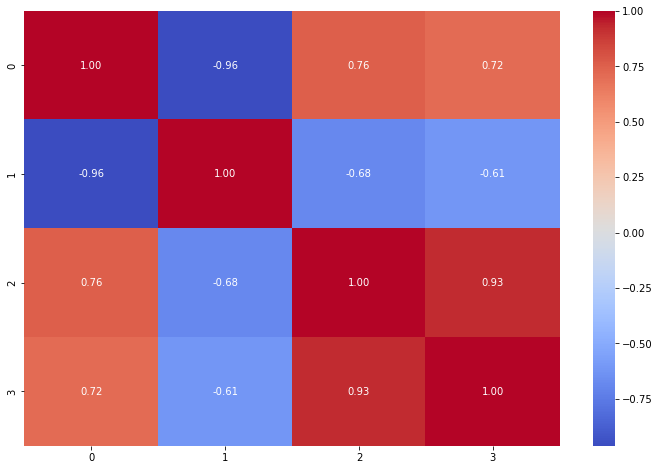

In [6]:
corr_matrix = df_train.corr()

# Plot the correlation matrix
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.show()

Rank correlation matrix

In [7]:
n_train = len(df_train)

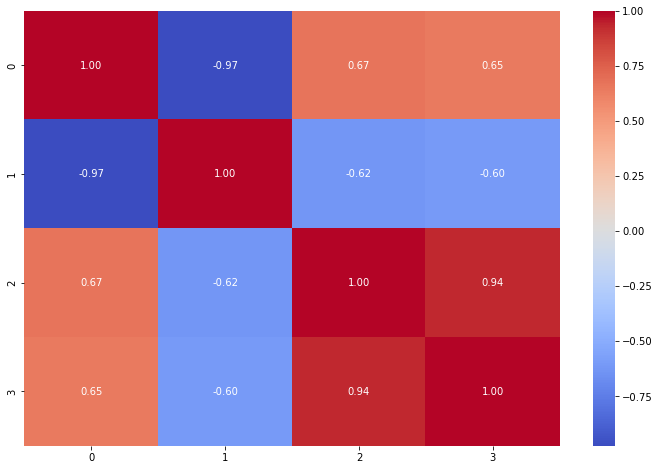

In [8]:
corr_matrix = df_train.corr('spearman')

# Plot the correlation matrix
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.show()

Confidence:  0.75


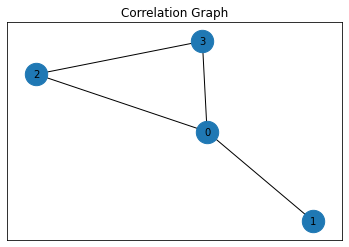

Confidence:  0.8


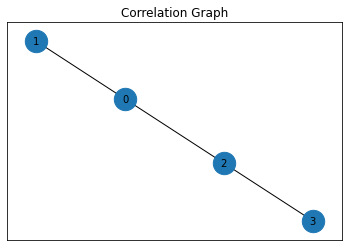

Confidence:  0.9


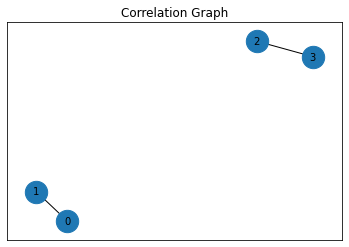

Confidence:  0.95


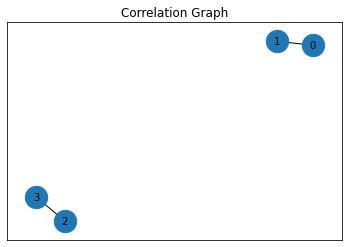

In [9]:
from causality.discovery import spearman_correlations_to_tstudent, t_critical_value
from causality.utilities import plot_correlation_graph, adjacency_matrix_from_tstudent


confidence_levels = [0.75, 0.8, 0.9, 0.95]

for i in range(len(corr_matrix.columns)):
    corr_matrix.loc[i,i] = 0
tstudent_values = spearman_correlations_to_tstudent(corr_matrix)

for confidence in confidence_levels:
    print('Confidence: ', confidence)
    critical_value = t_critical_value(confidence, n_train - 2)
    adj_mat = adjacency_matrix_from_tstudent(tstudent_values, critical_value)
    plot_correlation_graph(adj_mat)

Ground truth

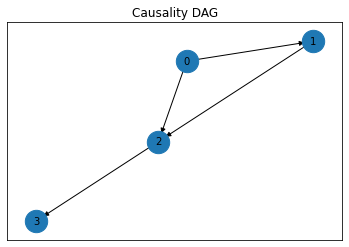

In [10]:
from causality.utilities import plot_DAG_from_adjacency

ground_truth_DAG = pd.read_csv('../data/nonlin_simpson/adj_matrix.csv', header=None)
plot_DAG_from_adjacency(ground_truth_DAG)


In principle, there should be no correlation between 1 and 3 if conditioned on 2

In [11]:
from causality.discovery import ScikitLinearRegressor

model1 = ScikitLinearRegressor(df_train, cols=[2], target_col=1)
model2 = ScikitLinearRegressor(df_train, cols=[2], target_col=3)
model1.fit()
model2.fit()
# print('Model 1: 2 -> 1')
# print(model1.coef_)
# print('Model 2: 2 -> 3')
# print(model2.coef_)
# model3 = ScikitLinearRegressor(df_train, cols=[1], target_col=3)
# model3.fit()
# # print(model3.coef_)
# model4 = ScikitLinearRegressor(df_train, cols=[3], target_col=1)
# model4.fit()
# print(model4.coef_)

0.046688533245018725 0.03681517071035599


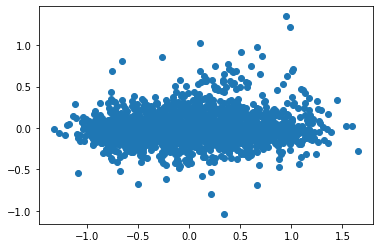

In [12]:

correlation, p_value = spearmanr(model1.residuals, model2.residuals)
print(correlation, p_value)
plt.scatter(model1.residuals, model2.residuals)

Not very correlated, but p-value inflated

Performing same analysis on 0,1,2 conditioned on 2 should give correlation

-0.9338742005191586 0.0


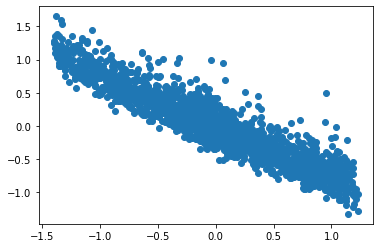

In [13]:

model5 = ScikitLinearRegressor(df_train, cols=[2], target_col=0)
model6 = ScikitLinearRegressor(df_train, cols=[2], target_col=1)
model5.fit()
model6.fit()
correlation, p_value = spearmanr(model5.residuals, model6.residuals)
print(correlation, p_value)
plt.scatter(model5.residuals, model6.residuals)

In [14]:
# from causality.discovery import ScikitLinearRegressor

# model = ScikitLinearRegressor(df_train)
# model.fit()
# model.compute_p_values()


Correlation fork should be between 0, 1, and 2 instead of 2,3,0

1 - 0 - 2 - 3 might make sense

Any attempt at unveiling directionality needs conditional tests -> difficult for continuous variables

Investigate linear models next

Then, investigate local search with BIC

Then try better models (neural networks for example)

Then, try double ML

In [18]:
from causality.discovery import check_DAG
adj_mat = np.array([[0, 1, 0], [0, 0, 1], [1, 0, 0]])
check_DAG(adj_mat)
adj_mat = np.array([[0, 0, 0], [0, 0, 1], [1, 0, 0]])
check_DAG(adj_mat)

False
True
